In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# log_theta_file = "paad_mixed_08_003"
# cancer_type = "paad"
# event_file = "G12_PAADPANET_PM_z10_Events_30and5_Full"
# n_ever_met = .8
# n_never_met = .2

log_theta_file = "luad_mixed_20_8_0035"
cancer_type = "luad"
event_file = "G13_LUAD_PM_z1_Events_20and8_Full"
n_ever_met = .65
n_never_met = .35


log_theta = pd.read_csv(
    f"../results/{cancer_type}/{log_theta_file}.csv", index_col=0)
tau1, tau2 = np.exp(log_theta.pop("Sampling").iloc[:2])
events = log_theta.columns
log_theta = log_theta.to_numpy()
n = log_theta.shape[0] - 1

data = np.load(f"../simulations/{cancer_type}/{log_theta_file}.npy")

stats = pd.read_csv(
    f"../data/{cancer_type}/stats_{event_file}.csv", index_col=0, header=[0, 1])


In [2]:
# get the counts from the columns and rename them to just what they describe
relations = dict()
for column_name in stats.columns.get_level_values(0).to_list():
    name, no = column_name.split(" (")
    relations[name] = int(no[:-1])
stats.columns = pd.MultiIndex.from_tuples(
    [(c[0].split(" ")[0], c[1]) for c in stats.columns])
print(relations)
stats.head()


{'Coupled': 358, 'Prim_no_met': 561, 'Prim_met': 1576, 'Met': 1842}


Coupled                                Prim_no_met  \
                     absent present_prim present_met  both     present   
P.Mut.TP53             0.42         0.06        0.08  0.44        0.30   
P.Mut.KRAS             0.75         0.05        0.03  0.17        0.40   
P.chr5.amp.single.1    0.53         0.11        0.16  0.19        0.22   
P.chr8.amp.single.1    0.55         0.14        0.19  0.12        0.21   
P.Mut.EGFR             0.57         0.01        0.02  0.39        0.32   

                    Prim_met     Met  
                     present present  
P.Mut.TP53              0.47    0.59  
P.Mut.KRAS              0.37    0.31  
P.chr5.amp.single.1     0.29    0.37  
P.chr8.amp.single.1     0.28    0.39  
P.Mut.EGFR              0.26    0.30

In [3]:
# setup comparison dataframe to put real and simulated data frequencies next to each other
comparison = stats.copy()
comparison.drop(("Coupled", "absent"), axis=1, inplace=True)
comparison.columns = pd.MultiIndex.from_tuples(
    [(*c, "data") for c in comparison.columns])


In [4]:
# simulate t1s and "freeze" all simulated datapoints at these times
times1 = np.random.exponential(1/tau1, size=(data.shape[0], 1))
simulated_timed_1 = np.where(data < times1, 1, 0)
# simulate \Delta ts and "freeze" all simulated datapoints at t2
times2 = np.random.exponential(1/tau2, size=(data.shape[0], 1))
simulated_timed_2 = np.where(data < times1 + times2, 1, 0)


In [5]:
# get subsets of simulated data
coupled_pt = simulated_timed_1[simulated_timed_1[:, -1].astype(bool)][:, ::2]
coupled_met = simulated_timed_2[simulated_timed_1[:, -
                                                  1].astype(bool)][:, list(range(1, 2*n, 2)) + [-1]]
coupled_both = coupled_met & coupled_pt
coupled_met_only = coupled_met - coupled_both
coupled_pt_only = coupled_pt - coupled_both
met = simulated_timed_1[simulated_timed_1[:, -
                                          1].astype(bool)][:, list(range(1, 2*n, 2)) + [-1]]
prim_no_met = simulated_timed_1[np.logical_not(
    simulated_timed_2[:, -1])][:, ::2]
prim_met = simulated_timed_1[simulated_timed_1[:, -1].astype(bool)][:, ::2]


In [6]:
# Get frequencies and put into the comparison matrix
comparison["Prim_no_met", "present", "simulated"] = prim_no_met.sum(
    axis=0) / prim_no_met.shape[0]
comparison["Prim_met", "present", "simulated"] = prim_met.sum(
    axis=0) / prim_met.shape[0]
comparison["Met", "present", "simulated"] = met.sum(axis=0) / met.shape[0]
comparison["Coupled", "both", "simulated"] = coupled_both.sum(
    axis=0) / coupled_both.shape[0]
comparison["Coupled", "present_prim", "simulated"] = coupled_pt_only.sum(
    axis=0) / coupled_pt_only.shape[0]
comparison["Coupled", "present_met", "simulated"] = coupled_met_only.sum(
    axis=0) / coupled_met_only.shape[0]
comparison.drop("Seeding", inplace=True)


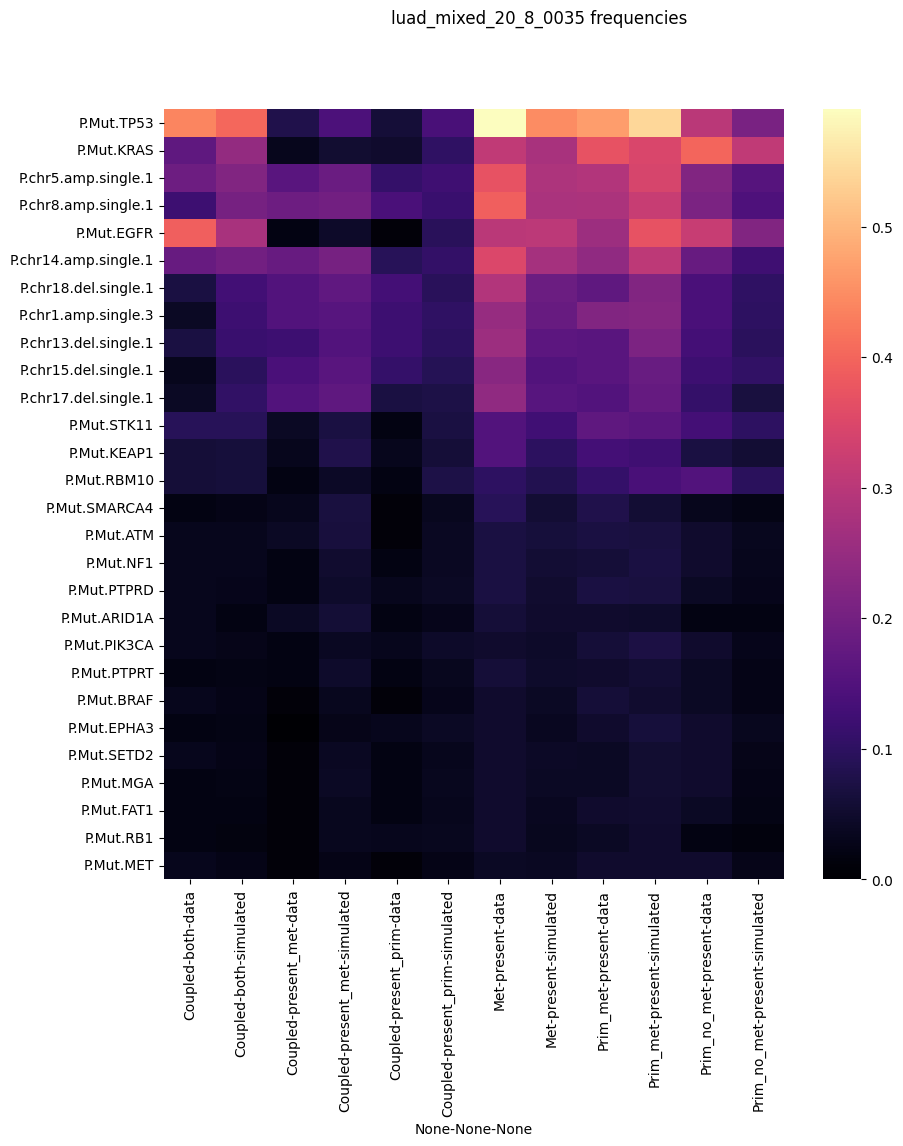

In [7]:
f, a = plt.subplots(figsize=(10, 10))
comparison.sort_index(axis=1, inplace=True)
sns.heatmap(comparison, cmap="magma", ax=a)
f.suptitle(f"{log_theta_file} frequencies")
f.savefig(
    f"./../viz/{cancer_type}/{log_theta_file}_frequencies.png", bbox_inches="tight")


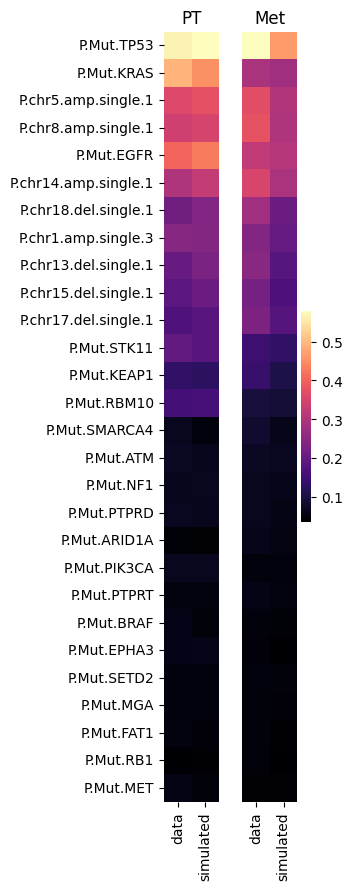

In [8]:
f, a = plt.subplots(ncols=2, figsize=(2, 10))
comparison.sort_index(axis=1, inplace=True)
poster_comparison = pd.DataFrame(index=comparison.index, columns=pd.MultiIndex.from_tuples(
    [("PT", "data"), ("PT", "simulated"), ("Met", "data"), ("Met", "simulated")]))

# Get back from frequencies to counts again. Also weight with the relations never/ever met
poster_comparison["PT"] = \
    ((comparison["Coupled", "present_prim"] + comparison["Coupled", "both"]) * relations["Coupled"] + \
        comparison["Prim_met", "present"] * relations["Prim_met"]
        ) / (relations["Prim_met"] + relations["Coupled"]) * n_ever_met +\
                                              comparison["Prim_no_met", "present"] * n_never_met
poster_comparison["Met"] = comparison["Met", "present"] * relations["Met"] + \
                            (comparison["Coupled", "present_met"] + comparison["Coupled", "both"]) * relations["Coupled"]
poster_comparison["Met"] /= relations["Coupled"] + relations["Met"]

sns.heatmap(poster_comparison["PT"],
            cmap="magma", ax=a[0], square="True", cbar=False)
sns.heatmap(poster_comparison["Met"],
            cmap="magma", ax=a[1], square="True")
_ = a[1].set_yticks([])
a[0].set_title("PT")
a[1].set_title("Met")
f.savefig(
    f"./../viz/{cancer_type}/{log_theta_file}_frequencies_simple.png", bbox_inches="tight", dpi=300)

In [83]:
def cooccurrence(dat, normalize):
    k = dat.shape[1]
    cooc = np.zeros((k, k))
    for i in range(k):
        cooc[i] = dat[dat[:, i].astype(bool)].sum(axis=0)
    if normalize:
        cooc /= dat.shape[0]
    return cooc

In [84]:
cooc_met = (cooccurrence(coupled_met, normalize=True) * relations["Coupled"] + cooccurrence(
    met, normalize=True) * relations["Met"]) / (relations["Coupled"] + relations["Met"])
cooc_pt = \
    n_ever_met * (
        cooccurrence(coupled_met_only, normalize=True) * relations["Coupled"] + \
        cooccurrence(prim_met, normalize=True) * relations["Prim_met"]) / \
            (relations["Prim_met"] + relations["Coupled"]) + \
    n_never_met * cooccurrence(prim_no_met, normalize=True)

np.savetxt(f"{log_theta_file}_simulated_met_cooc.csv", cooc_met, delimiter=",")
np.savetxt(f"{log_theta_file}_simulated_pt_cooc.csv", cooc_pt, delimiter=",")
